In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
import stan
import nest_asyncio
from mpl_toolkits.mplot3d import Axes3D
nest_asyncio.apply()
import itertools
import time
import arviz as az
import mpltern
import ternary

In [2]:
# Distribution parameters
alpha_b = 6  # Beta distribution for 'b'
beta_param_b = 1.7
mu_c = 0.4  # Normal distribution for 'c'
sigma_c = 0.1

np.random.seed(42)

# Function to sample a score based on the component
def sample_score(component):
    if component == 'c':
        return np.random.normal(mu_c, sigma_c)
    elif component == 'b':
        return np.random.beta(alpha_b, beta_param_b)
    else:
        raise ValueError(f"Unknown component: {component}")

# Generate unique permutations
def unique_permutations(elements):
    return list(set(itertools.permutations(elements)))

# Generate unique permutations for 'bbcc'
bbcc_permutations = unique_permutations(['b', 'b', 'c', 'c'])

# Generate scores with labels
def generate_scores_with_labels(class_label):
    if class_label == 'bbbb':
        scores = [sample_score('b') for _ in range(4)]
        labels = ['b', 'b', 'b', 'b']
    elif class_label == 'cccc':
        scores = [sample_score('c') for _ in range(4)]
        labels = ['c', 'c', 'c', 'c']
    elif class_label == 'bbcc':
        perm = np.random.choice(len(bbcc_permutations))  # Select a unique permutation
        labels = bbcc_permutations[perm]
        scores = [sample_score(comp) for comp in labels]
    else:
        raise ValueError(f"Unknown class: {class_label}")
    
    return scores, labels

# Generate classes based on probabilities and sample the scores
N = 1000
classes = ["bbbb", "bbcc", "cccc"]
p = [0.2, 0.3, 0.5]  # Probabilities for each class
class_column = np.random.choice(classes, size=N, p=p)

data = []
for c in class_column:
    try:
        scores, labels = generate_scores_with_labels(c)
        data.append(scores + [c] + list(labels))  # Add scores, class, and labels
    except ValueError as e:
        print(e)  # just in case

# Create the DataFrame with new label columns
df = pd.DataFrame(data, columns=['s1', 's2', 's3', 's4', 'class', 'label_s1', 'label_s2', 'label_s3', 'label_s4'])
df

,s1,s2,s3,s4,class,label_s1,label_s2,label_s3,label_s4
0,0.506457,0.411961,0.778973,0.674267,bbcc,c,c,b,b
1,0.481848,0.413385,0.444664,0.378673,cccc,c,c,c,c
2,0.512907,0.391958,0.353455,0.488652,cccc,c,c,c,c
3,0.259484,0.450103,0.295752,0.527793,cccc,c,c,c,c
4,0.768030,0.587644,0.581937,0.841299,bbbb,b,b,b,b
...,...,...,...,...,...,...,...,...,...
995,0.715412,0.958215,0.898450,0.584068,bbbb,b,b,b,b
996,0.417478,0.339612,0.582554,0.276071,cccc,c,c,c,c
997,0.909105,0.826531,0.820174,0.851671,bbbb,b,b,b,b
998,0.423943,0.454010,0.470065,0.451214,cccc,c,c,c,c


In [3]:
# Get the count of each class
class_counts = df['class'].value_counts()
print(class_counts)

# Calculate the fractions by dividing by the total N
class_fractions = class_counts / N

# Convert to list
class_fractions_list = class_fractions.tolist()

class_fractions_list_rounded = [round(fraction, 2) for fraction in class_fractions_list]
print('')
print(class_fractions_list_rounded,'data fraction')
print(p,'true fraction')

class
cccc    497
bbcc    278
bbbb    225
Name: count, dtype: int64

[0.5, 0.28, 0.23] data fraction
[0.2, 0.3, 0.5] true fraction


In [4]:
m = 20

# Function to rescale values to the interval [1, m] and convert to integers
def rescale_to_interval(values, m):
    return np.round(values * (m - 1) + 1).astype(int)

# Create a copy of the original DataFrame
df_rescaled = df.copy()

# Apply rescaling to each score column in the new DataFrame
df_rescaled['s1'] = rescale_to_interval(df_rescaled['s1'], m)
df_rescaled['s2'] = rescale_to_interval(df_rescaled['s2'], m)
df_rescaled['s3'] = rescale_to_interval(df_rescaled['s3'], m)
df_rescaled['s4'] = rescale_to_interval(df_rescaled['s4'], m)

# Show the rescaled DataFrame
print(df_rescaled.head())

# Show the class counts in the rescaled DataFrame
print(df_rescaled['class'].value_counts())

# Verify the total number of rows in the rescaled DataFrame
print(len(df_rescaled))

   s1  s2  s3  s4 class label_s1 label_s2 label_s3 label_s4
0  11   9  16  14  bbcc        c        c        b        b
1  10   9   9   8  cccc        c        c        c        c
2  11   8   8  10  cccc        c        c        c        c
3   6  10   7  11  cccc        c        c        c        c
4  16  12  12  17  bbbb        b        b        b        b
class
cccc    497
bbcc    278
bbbb    225
Name: count, dtype: int64
1000


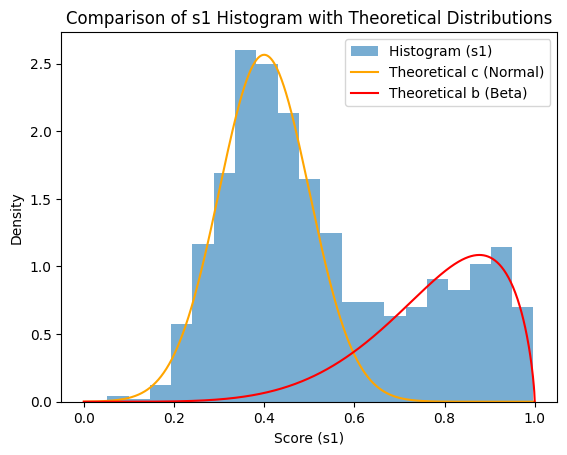

In [5]:
# Values for the x-axis
x = np.linspace(0, 1, 1000)  # Range of possible values for s1

# Theoretical distributions
pdf_c = norm.pdf(x, mu_c, sigma_c)  # Normal distribution for 'c'
pdf_b = beta.pdf(x, alpha_b, beta_param_b)  # Beta distribution for 'b'

# Plot the histogram of s1
plt.hist(df['s1'], bins=20, density=True, alpha=0.6, label='Histogram (s1)')

# Plot the theoretical distributions
plt.plot(x, pdf_c * df['label_s1'].value_counts()['c'] / N, label='Theoretical c (Normal)', color='orange')
plt.plot(x, pdf_b * df['label_s1'].value_counts()['b'] / N, label='Theoretical b (Beta)', color='red')

# Add labels and legend
plt.xlabel('Score (s1)')
plt.ylabel('Density')
plt.legend()
plt.title('Comparison of s1 Histogram with Theoretical Distributions')
plt.show()

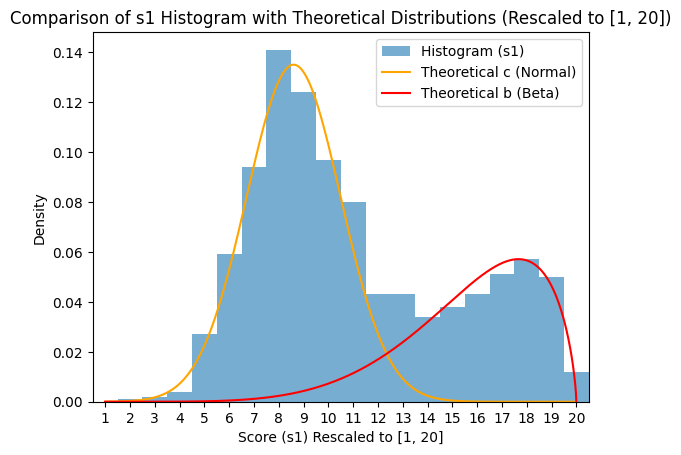

In [6]:
# Rescaled x-axis values to [1, m]
x_rescaled = np.linspace(1, m, 1000)  # Range of possible values for s1

# Adjust theoretical distributions to [1, m]
pdf_c_rescaled = norm.pdf((x_rescaled - 1) / (m - 1), mu_c, sigma_c) / (m - 1)  # Rescaled Normal for 'c'
pdf_b_rescaled = beta.pdf((x_rescaled - 1) / (m - 1), alpha_b, beta_param_b) / (m - 1)  # Rescaled Beta for 'b'


bin_edges = np.arange(0.5, m + 1.5, 1)
# Plot the rescaled histogram of s1
plt.hist(df_rescaled['s1'], bins=bin_edges, density=True, alpha=0.6, label='Histogram (s1)')

# Plot the rescaled theoretical distributions
plt.plot(x_rescaled, pdf_c_rescaled * df['label_s1'].value_counts()['c'] / N, label='Theoretical c (Normal)', color='orange')
plt.plot(x_rescaled, pdf_b_rescaled * df['label_s1'].value_counts()['b'] / N, label='Theoretical b (Beta)', color='red')

plt.xlim(0.5,m+0.5)
plt.xlabel(f'Score (s1) Rescaled to [1, {m}]')
plt.ylabel('Density')
plt.legend()
plt.title(f'Comparison of s1 Histogram with Theoretical Distributions (Rescaled to [1, {m}])')
plt.xticks(range(1, m+1))
plt.show()

In [7]:
# Retrieve the scores as a list
score = df_rescaled[['s1', 's2', 's3', 's4']].values.tolist()
print(score[:3])
print(len(score))

[[11, 9, 16, 14], [10, 9, 9, 8], [11, 8, 8, 10]]
1000


In [8]:
my_mixture_4d = """
functions {
  real partial_sum(array[,] int score_slice,
                   int start, int end,
                   vector yc,
                   vector yb,
                   vector theta)
{
    real permutation_factor = 1.0/6;
    real partial_target = 0;
    
    vector[3] lp;   //3 clases distintas: cccc, bbcc (+perm) y bbbb.
    vector[6] lp2;  //para que sea más cómodo la clase con permutaciones.
    
    int slice_length = end - start + 1;

    for (k in 1:slice_length) {
     lp2[1] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
     lp2[2] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
     lp2[3] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
     lp2[4] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
     lp2[5] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
     lp2[6] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yc)[score_slice[k,4]];

     lp[1] = log(yc)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yc)[score_slice[k,4]]; // esto es cccc.
     lp[2] = log_sum_exp(lp2);    //esto es bbcc + perm.
     lp[3] = log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yb)[score_slice[k,4]]; //esto es bbbb.

     partial_target += log_mix(theta, lp);
     }

    return partial_target;
  }
}

data {
  int<lower=1> m;  // steps in the discretization
  int<lower=1> N;  // data points
  array[N,4] int<lower=1, upper=m> score;  // b-tagging score for jet#1
}

parameters {
  simplex[3] theta;  // Mixture coefficients of 3 classes as a simplex
  
  simplex[m] w_c_mode;  // Dirichlet weights
  vector<lower=0>[m-1] a_c;  // Normal parameters for the background
  
  simplex[m] w_b_mode;  // Dirichlet weights for the signal bbbb
  vector<lower=0>[m-1] a_b;  // Normal parameters for the signal
}

transformed parameters {
  ordered[2] y_label_switch_1; 
  ordered[2] y_label_switch_2;

  vector[m] p_c;  // Approximate distribution for the background
  vector[m-1] sign_c;  // Signs for combination
  vector[m] logp_c;  // Log-probabilities
  
  sign_c = rep_vector(-1.0, m-1);
  p_c = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_c[j] = 1.0;
      }
    }
    logp_c[1] = 0.0;
    for (j in 2:m) {
      logp_c[j] = logp_c[j-1] + sign_c[j-1] * a_c[j-1];
    }
    p_c += softmax(logp_c) * w_c_mode[k];
  }

  vector[m] p_b;  // Approximate distribution for the signal
  vector[m-1] sign_b;  // Signs for combination
  vector[m] logp_b;  // Log-probabilities

  sign_b = rep_vector(-1.0, m-1);
  p_b = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_b[j] = 1.0;
      }
    }
    logp_b[1] = 0.0;
    for (j in 2:m) {
      logp_b[j] = logp_b[j-1] + sign_b[j-1] * a_b[j-1];
    }
    p_b += softmax(logp_b) * w_b_mode[k];
  }
  y_label_switch_1[1] = p_b[8];
  y_label_switch_1[2] = p_c[8];

  y_label_switch_2[1] = p_c[16];
  y_label_switch_2[2] = p_b[16];

}

model {
  int grainsize = 1;  // Adjust for parallel performance
  
  theta ~ dirichlet(rep_vector(1.0, 3));
  
  a_c ~ normal(0, 0.5);
  a_b ~ normal(0, 0.5);

  w_b_mode ~ dirichlet(rep_vector(1.0, m));
  w_c_mode ~ dirichlet(rep_vector(1.0, m));

  target += reduce_sum(partial_sum, score, grainsize, p_c, p_b, theta);
}


"""

In [9]:
# Start the timer
start_time_4d = time.time()

# Build and sample from the 2D mixture model
model_4d = stan.build(my_mixture_4d, data={'m': m, 'N': len(score), 'score':score}, random_seed=33)
fit_4d = model_4d.sample(num_chains=4, num_samples=1000,num_warmup=2000)
df_4d = fit_4d.to_frame()

# Stop the timer
end_time_4d = time.time()

# Calculate the elapsed time
elapsed_time_4d = end_time_4d - start_time_4d

# Print the elapsed time
print(f"Time taken to run the 2D model: {elapsed_time_4d:.2f} seconds")


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_8g7ewqhm/model_mit6bctr.stan', line 114, column 12: The
    variable partial_sum may not have been assigned a value before its use.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_mit6bctr_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 6.2503e-310, but should be greater than the previous element, 0.00169257 (in '/tmp/httpstan_w3smm_fr/model_mit6bctr.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_mit6bctr_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.11727, but should be greater than the previous element, 0.121051 (in '/tmp/httpstan_w3smm_fr/model_mit6bctr.stan', line 53, column 2 to col

  Exception: model_mit6bctr_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0534269, but should be greater than the previous element, 0.0534746 (in '/tmp/httpstan_w3smm_fr/model_mit6bctr.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_mit6bctr_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0534918, but should be greater than the previous element, 0.053511 (in '/tmp/httpstan_w3smm_fr/model_mit6bctr.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_mit6bctr_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.0488011, but should be greater than the previous element, 0.0494223 (in '/tmp/httpstan_w3smm_fr/model_mit6bctr.stan', line 54, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mode

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_mit6bctr_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118892, but should be greater than the previous element, 0.157309 (in '/tmp/httpstan_w3smm_fr/model_mit6bctr.stan', line 53, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_mit6bctr_namespace::log_prob: y_label_switch_2 is not a valid ordered vector. The element at 2 is 0.00463803, but should be greater than 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_mit6bctr_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0714286, but should be greater than the previous element, 0.0714286 (in '/tmp/httpstan_w3smm_fr/model_mit6bctr.stan', line 53, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_mit6bctr_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.137514, but should be greater than the previous element, 0.151192 (in '/tmp/httpstan_w3smm_fr/model_mit6bctr.stan', line 53, column 2 to colum

Time taken to run the 2D model: 147.50 seconds


In [10]:
df_ordenado = df_4d.sort_values(by='lp__', ascending=False)
#df_ordenado[:5]

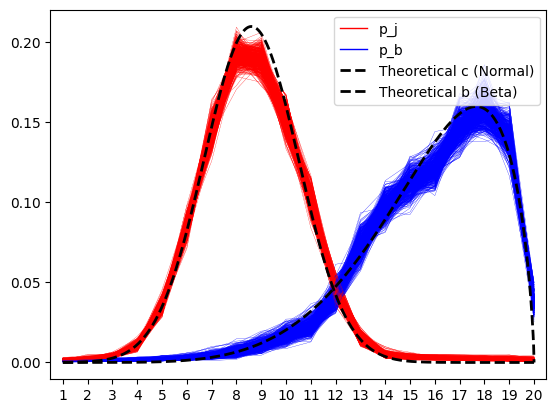

In [11]:
#Normalizing and plotting inferred distributions
for i in range(500):
    # Extract the p_c and p_b values for the current sample
    p_c_values = np.array([df_ordenado.iloc[i]['p_c.' + str(x)] for x in range(1, 21)])
    p_b_values = np.array([df_ordenado.iloc[i]['p_b.' + str(x)] for x in range(1, 21)])
    # Normalize the values
    p_c_values_normalized = p_c_values / p_c_values.sum()
    p_b_values_normalized = p_b_values / p_b_values.sum()
    
    # Plot the normalized curves
    if i == 0:
        plt.plot(range(1, 21), p_c_values_normalized,lw=1, color='red', label='p_j')
        plt.plot(range(1, 21), p_b_values_normalized, lw=1,color='blue', label='p_b')

    else:
        plt.plot(range(1, 21), p_c_values_normalized, lw=0.2,color='red')
        plt.plot(range(1, 21), p_b_values_normalized, lw=0.2,color='blue')


# Plot the rescaled theoretical distributions
plt.plot(x_rescaled, pdf_c_rescaled, ls='--', lw=2, label='Theoretical c (Normal)', color='black')
plt.plot(x_rescaled, pdf_b_rescaled, ls='--', lw=2, label='Theoretical b (Beta)', color='black')


#plt.hist(rescaled_data['s1'],bins=np.arange(1,m+2)-0.5,density=True,label='Real data')

plt.xticks(np.arange(1,m+1))
plt.xlim(1-0.5,m+0.5)
plt.legend()
#plt.grid(alpha=0.5)
plt.show()

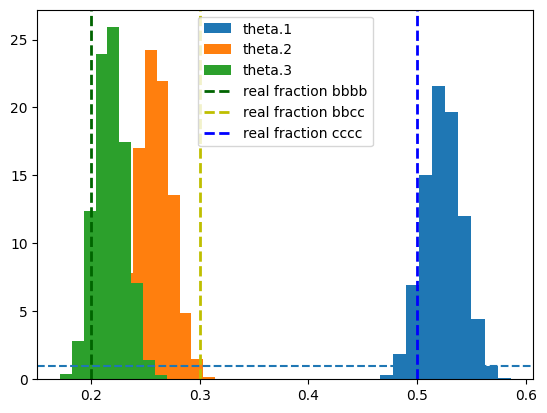

In [24]:
plt.hist(df_4d['theta.1'], density=1, label = 'theta.1')
plt.hist(df_4d['theta.2'],  density=1, label = 'theta.2')
plt.hist(df_4d['theta.3'], density=1,  label = 'theta.3')

#recordamos:
#classes = ["bbbb", "bbcc", "cccc"]
#p = [0.2, 0.3, 0.5]  # Probabilities for each class

plt.axvline(p[0],ls='--',color='darkgreen',lw=2,label='real fraction bbbb')
plt.axvline(p[1],ls='--',color='y',lw=2,label='real fraction bbcc')
plt.axvline(p[2],ls='--',color='b',lw=2,label='real fraction cccc')
plt.axhline(y=1, linestyle='dashed')
plt.legend()
plt.show()

/home/tomas/.local/lib/python3.8/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


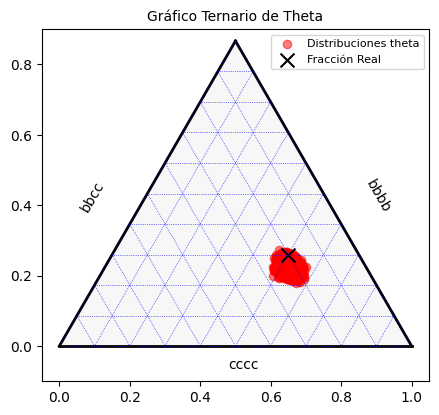

In [13]:
theta1 = df_4d['theta.1']  # Se asocia a una clase
theta2 = df_4d['theta.2']
theta3 = df_4d['theta.3']

# Calcular las fracciones reales de cada clase
real_fractions = {
    'bbbb': p[0],
    'bbcc': p[1],
    'cccc': p[2],
}

# Configurar el tamaño de la figura
scale = 1.0  # Escala del gráfico ternario
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

# Crear el gráfico ternario
figure, tax = ternary.figure(ax=ax, scale=scale)
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=0.1)

# Agregar los puntos de theta al gráfico ternario
points = list(zip(theta1, theta2, theta3))
tax.scatter(points, marker='o', color='red', alpha=0.5, label="Distribuciones theta")

# Coordenadas de la fracción real en el gráfico ternario
real_fraction_coords = (real_fractions['cccc'], real_fractions['bbcc'], real_fractions['bbbb'])

# Agregar una cruz en el gráfico para la fracción real
tax.scatter([real_fraction_coords], marker='x', color='black', s=100, label="Fracción Real")

# Etiquetas y ajustes basados en las fracciones reales
tax.left_axis_label("bbcc", fontsize=10, offset=0.16)
tax.right_axis_label("bbbb", fontsize=10, offset=0.16)
tax.bottom_axis_label("cccc", fontsize=10, offset=-0.08)
tax.set_title("Gráfico Ternario de Theta", fontsize=10)
tax.legend(fontsize=8)

# Mostrar el gráfico
tax.show()

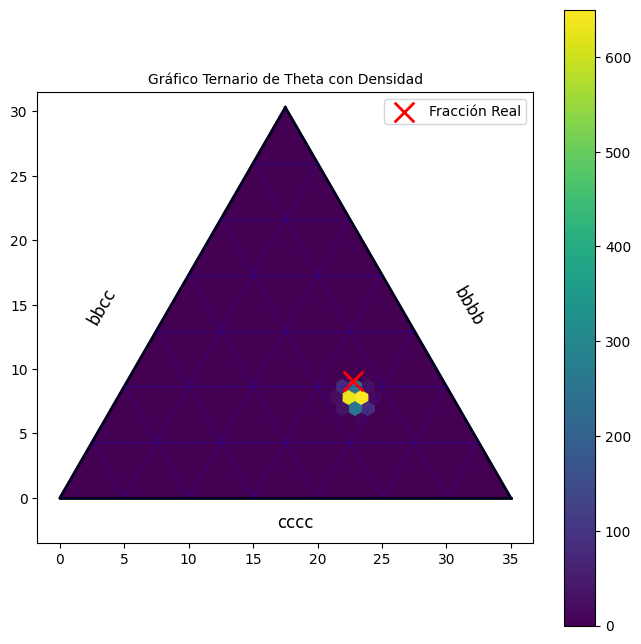

In [14]:
# Configurar el tamaño de la figura
scale = 35  # Ajustar el scale según el número de puntos
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# Crear el gráfico ternario
figure, tax = ternary.figure(ax=ax, scale=scale)
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)  # Ajustar el multiple según el scale

# Crear los puntos para el gráfico ternario
points = np.array(list(zip(theta1, theta2, theta3)))

# Crear el histograma de densidad
hist, edges = np.histogramdd(points, bins=[scale+1, scale+1, scale+1], range=[[0, 1], [0, 1], [0, 1]])

# Convertir el histograma a un diccionario para la función heatmap
heatmap_data = {}
for i in range(hist.shape[0]):
    for j in range(hist.shape[1]):
        k = scale - i - j
        if k >= 0:
            heatmap_data[(i, j)] = hist[i, j, k]

# Dibujar el heatmap en el gráfico ternario
tax.heatmap(heatmap_data, scale=scale, style="hexagonal", cmap='viridis')

# Coordenadas de la fracción real en el gráfico ternario
real_fraction_coords = (real_fractions['cccc'] * scale, real_fractions['bbcc'] * scale, real_fractions['bbbb'] * scale)

# Agregar una cruz en el gráfico para la fracción real
tax.scatter([real_fraction_coords], marker='x', color='red',lw=2, s=200, label="Fracción Real")

# Etiquetas y ajustes basados en las fracciones reales
tax.left_axis_label("bbcc", fontsize=12, offset=0.16)
tax.right_axis_label("bbbb", fontsize=12, offset=0.16)
tax.bottom_axis_label("cccc", fontsize=12, offset=-0.08)
tax.set_title("Gráfico Ternario de Theta con Densidad", fontsize=10)
tax.legend(fontsize=10)

# Mostrar el gráfico
tax.show()

In [15]:
mydata = df_4d[['theta.1','theta.2','theta.3']]   #cccc, bbcc, bbbb
mydata = np.round(mydata,2)
tmp = []
for i in range(101):
    for j in range(101-i):
        tmp.append([i/100,j/100])
ternary_data = pd.DataFrame(tmp, columns=['t','r'])  
ternary_data['l'] = np.round([1]*len(ternary_data) - ternary_data['t'] - ternary_data['r'],2) # complete third column in such a way that all three columns add to 1
ternary_data['v'] = [0] * len(ternary_data)        
total = len(mydata)
delta = 1/total
print(total,delta)
ternary_data

4000 0.00025


,t,r,l,v
0,0.00,0.00,1.00,0
1,0.00,0.01,0.99,0
2,0.00,0.02,0.98,0
3,0.00,0.03,0.97,0
4,0.00,0.04,0.96,0
...,...,...,...,...
5146,0.98,0.01,0.01,0
5147,0.98,0.02,0.00,0
5148,0.99,0.00,0.01,0
5149,0.99,0.01,0.00,0


In [25]:
force_uniform = 5  #solo es distinto de 1 o no

if force_uniform != 1:
    for k in range(total):
        ternary_data.loc[(ternary_data['t'] == mydata.iloc[k][0]) & (ternary_data['r'] == mydata.iloc[k][1]),['v']] += delta
else:
    ternary_data['v'] = [1/total] * len(ternary_data) # uniform data if force_uniform == 1 
    
t, r, l, v = ternary_data['t'],ternary_data['r'],ternary_data['l'],ternary_data['v']

prob_true = np.round(ternary_data[(ternary_data['t'] == 0.5) & (ternary_data['r'] == 0.3)]['v'].values[0],5)
print(prob_true, delta)
ternary_data

0.0045 0.00025


,t,r,l,v
0,0.00,0.00,1.00,0.0
1,0.00,0.01,0.99,0.0
2,0.00,0.02,0.98,0.0
3,0.00,0.03,0.97,0.0
4,0.00,0.04,0.96,0.0
...,...,...,...,...
5146,0.98,0.01,0.01,0.0
5147,0.98,0.02,0.00,0.0
5148,0.99,0.00,0.01,0.0
5149,0.99,0.01,0.00,0.0


In [17]:
ternary_data[(ternary_data['t'] == 0.2) & (ternary_data['r'] == 0.5)]['v'].values[0]

0.0

fraction mean: [0.5233475 0.218095  0.2585575] 
Absolute distance: 0.051


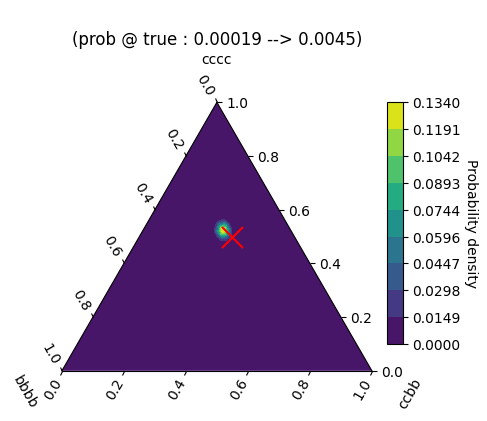

In [26]:
fraction_mean =np.array([np.average(ternary_data['t'], weights=ternary_data['v']),np.average(ternary_data['l'], weights=ternary_data['v']),np.average(ternary_data['r'], weights=ternary_data['v'])])
distance = np.round(np.linalg.norm(fraction_mean - np.array([0.5,0.2,0.3])),3)
print('fraction mean:', fraction_mean,'\nAbsolute distance:',distance)
# These values are for controlling the color-bar scale, and here they are
# explicitly given just to make the same color-bar scale for all the plots.
# In general, you may not need to explicitly specify them.
vmin = 0.0
vmax = max(v)
#vmax = 0.016  # test to use same colorbar level in all plots. I don't like it
if force_uniform == 1: vmax = 1   # forced uniform desitribution
levels = np.round(np.linspace(vmin, vmax, 10),4)

# Configura la figura
fig = plt.figure(figsize=(4, 4))
plot_number = 1
ax = fig.add_subplot(1, 1, plot_number, projection='ternary')  # Proyección ternaria con mpltern

# Graficar con tricontourf
cs = ax.tricontourf(t, l, r, v, levels=levels)
ax.set_tlabel('cccc')
ax.set_llabel('bbbb')
ax.set_rlabel('ccbb')

# Ajusta las posiciones de las etiquetas
ax.taxis.set_label_position('corner')
ax.laxis.set_label_position('corner')
ax.raxis.set_label_position('corner') 

# Configura el título del gráfico
ax.set_title('\n(prob @ true : '+str(np.round(1/len(ternary_data),5))+' --> '+str(prob_true)+')')
if force_uniform == 1: ax.set_title('Uniform prior\n(prob @ true : '+str(np.round(1/len(ternary_data),5))+')')         # title for uniform
# Añade scatter para el punto específico
ax.scatter([0.5], [0.2], [0.3], s=230, color='red', marker='x')

# Añade colorbar
cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar = fig.colorbar(cs, cax=cax)
colorbar.set_label('Probability density', rotation=270, va='baseline')

# Muestra el gráfico
plt.show()

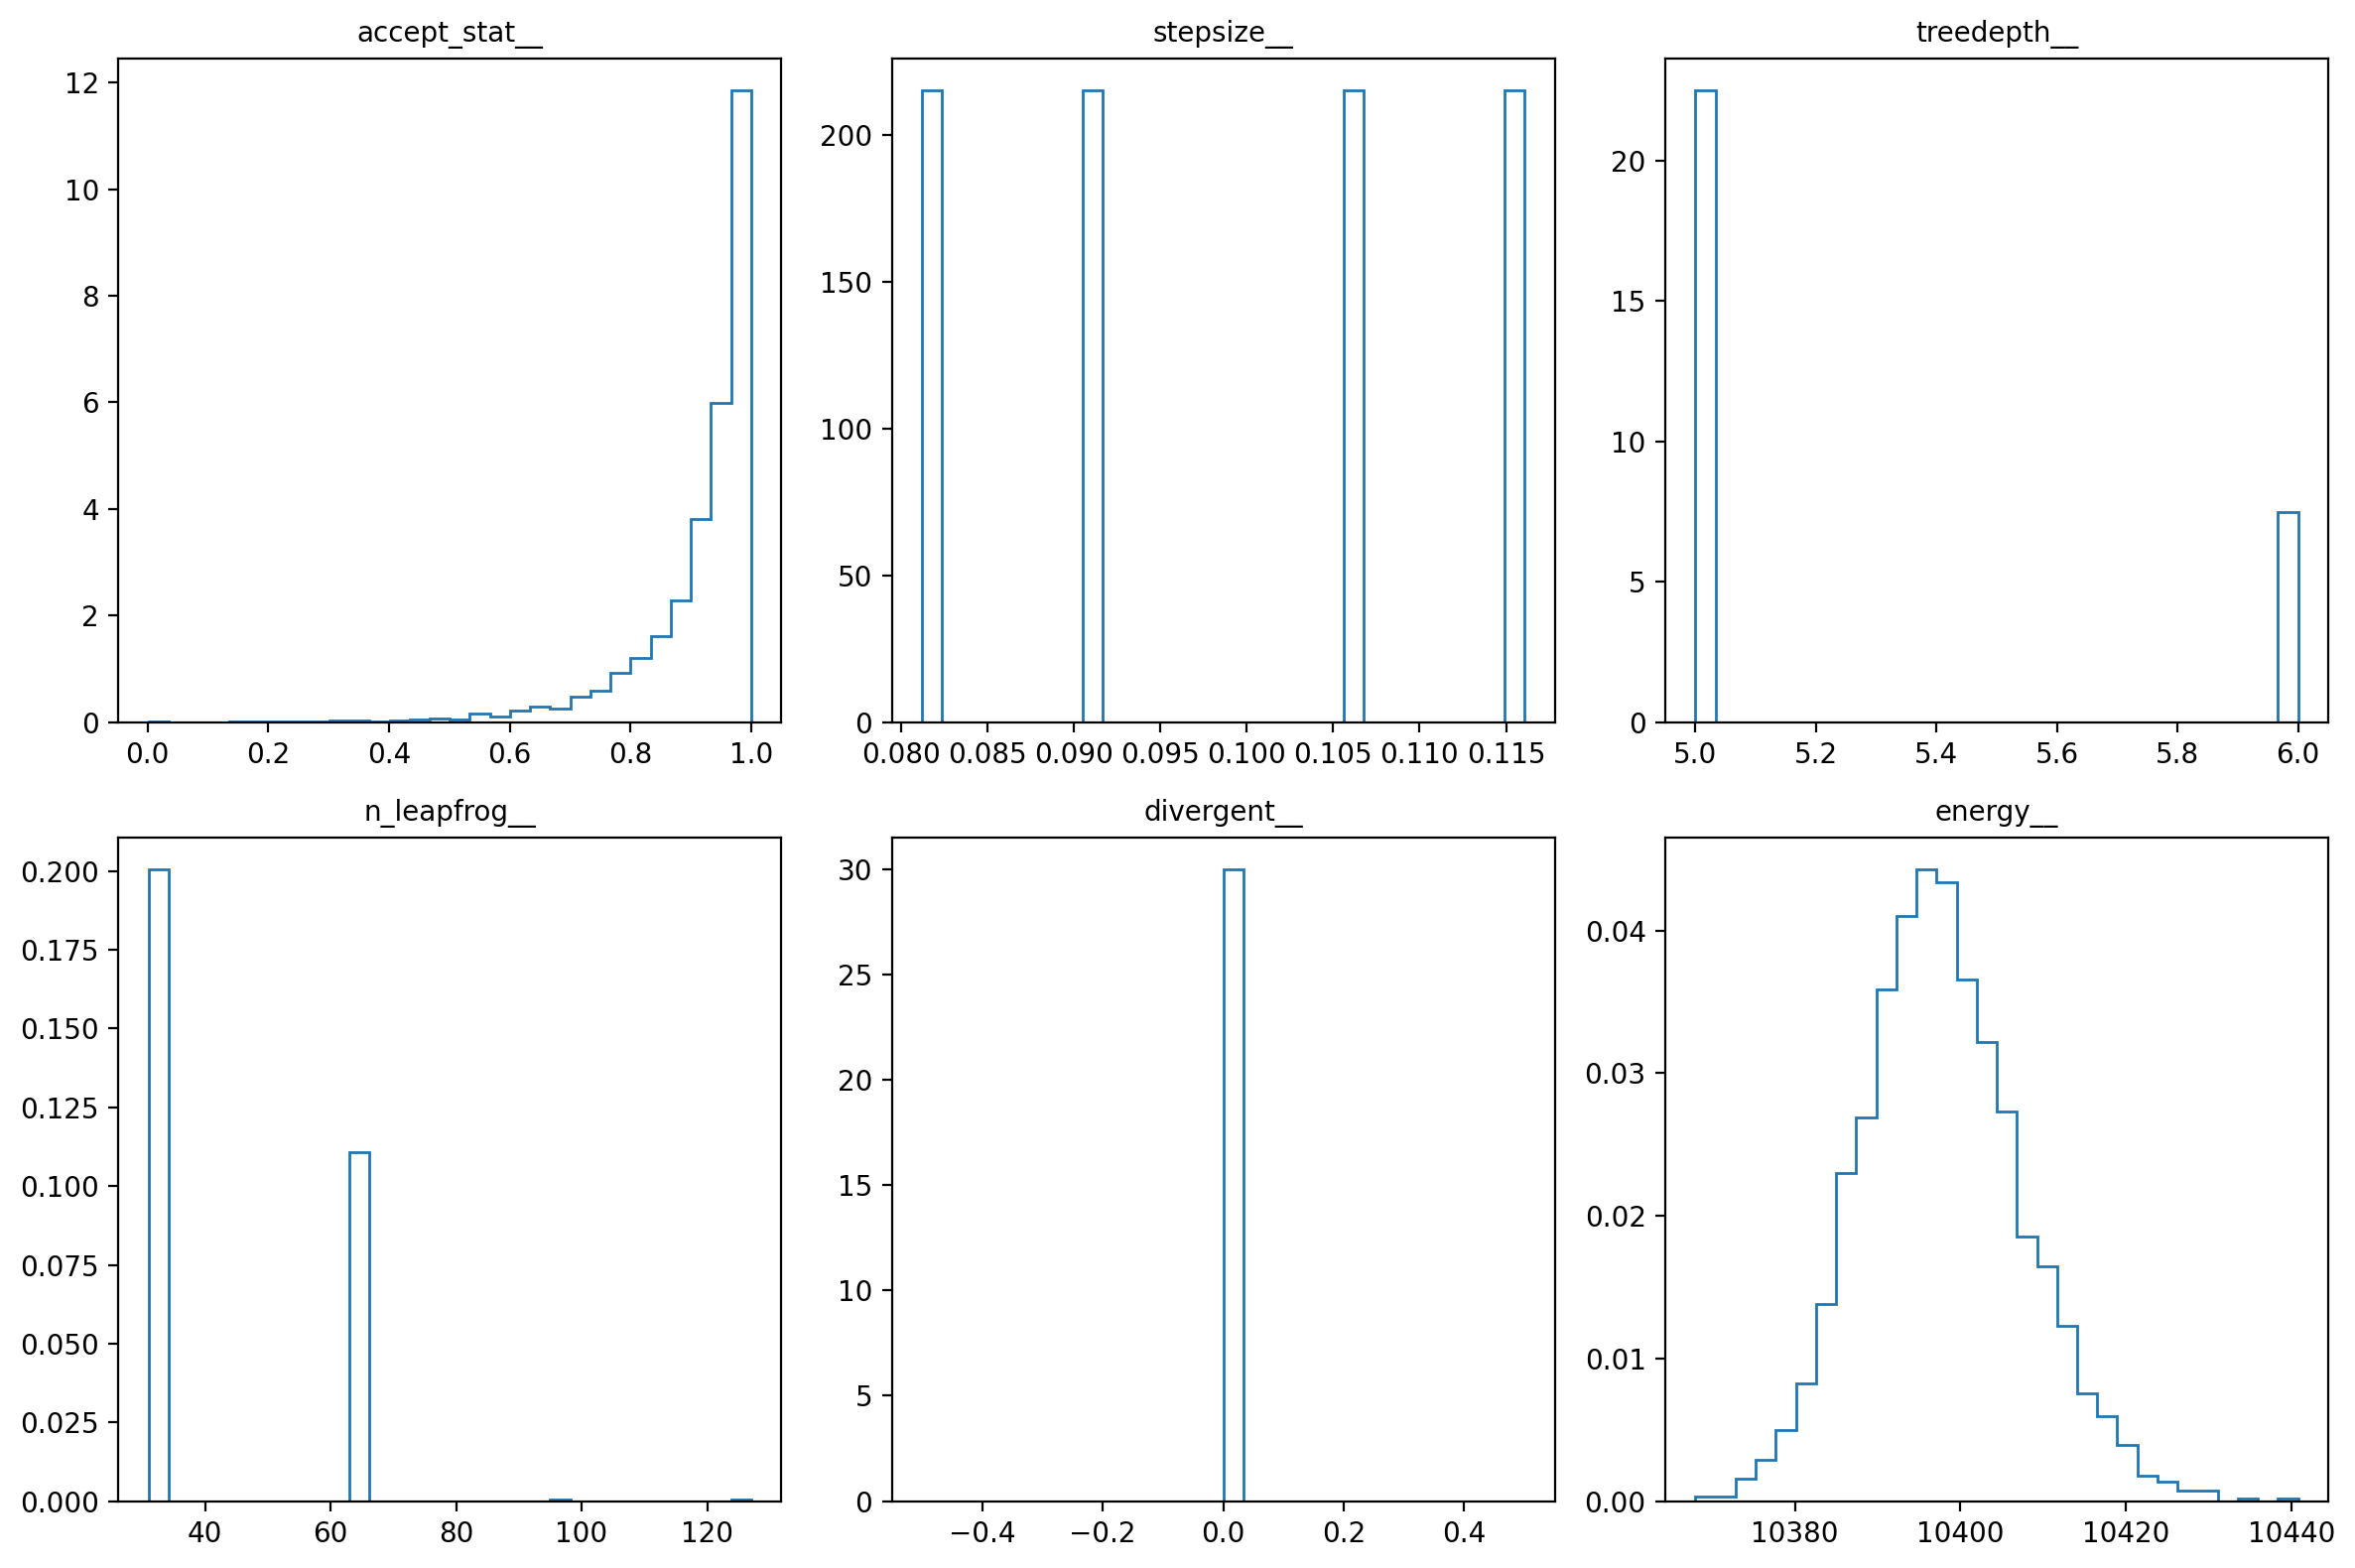

In [19]:
# Now define the posterior_4d with the relevant diagnostics columns
posterior_4d = df_4d[['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__']]

# Create subplots for each of the 6 diagnostic parameters
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=200)

# List of the diagnostic parameters
parameters = ['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__']

# Loop over the parameters and create histograms in subplots
for i, param in enumerate(parameters):
    row = i // 3  # Define the row for the subplot
    col = i % 3   # Define the column for the subplot
    axes[row, col].hist(posterior_4d[param], bins=30, histtype='step', density=True)
    axes[row, col].set_title(param, fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [20]:
posterior = az.from_pystan(fit_4d)

# Get the ArviZ summary
summary_df = az.summary(posterior)

summary_df.head(20)

/home/tomas/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/tomas/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.523,0.018,0.491,0.556,0.000,0.000,5027.0,3107.0,1.0
theta[1],0.259,0.016,0.227,0.286,0.000,0.000,4424.0,3066.0,1.0
theta[2],0.218,0.014,0.193,0.245,0.000,0.000,5630.0,3165.0,1.0
w_c_mode[0],0.001,0.001,0.000,0.002,0.000,0.000,3151.0,2096.0,1.0
w_c_mode[1],0.001,0.001,0.000,0.003,0.000,0.000,3246.0,1730.0,1.0
w_c_mode[2],0.001,0.001,0.000,0.003,0.000,0.000,3741.0,2269.0,1.0
w_c_mode[3],0.003,0.002,0.000,0.007,0.000,0.000,3727.0,1992.0,1.0
w_c_mode[4],0.012,0.009,0.000,0.029,0.000,0.000,2788.0,2259.0,1.0
w_c_mode[5],0.042,0.030,0.000,0.095,0.001,0.000,2685.0,1920.0,1.0
w_c_mode[6],0.105,0.067,0.000,0.215,0.001,0.001,2428.0,1408.0,1.0


In [21]:
summary_df['r_hat'].values

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

In [22]:
# Filter the rows where 'r_hat' is NaN
nan_rhat_df = summary_df[summary_df['r_hat'].isna()]

# Convert to DataFrame if not already
nan_rhat_df = pd.DataFrame(nan_rhat_df)

nan_rhat_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sign_c[0],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
sign_c[1],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
sign_c[2],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
sign_c[3],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
sign_c[4],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
sign_c[5],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
sign_c[6],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
sign_c[7],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
sign_c[8],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
sign_c[9],1.0,0.0,1.0,1.0,0.0,0.0,4000.0,4000.0,NaN
